# 2005 UD Polarimetric Phase Curve Fitting

The dataset is composed of two components:

1. MSI data obtained in this work.
2. The data from [Devogele](https://ui.adsabs.harvard.edu/abs/2020PSJ.....1...15D/abstract), revised by Jooyeon Geem after retrieving the original FITS data (2021 Jan-Mar). Also the data at the largest phase angle (α=106.47˚) is analyzed.

As a part of the publication of IshiguroM+ 2019 (in prep), here I provide full of the analysis code.

## 1. Installation

### 1-1. pymc3
On terminal (Anaconda Prompt or Git Bash on windows)
```
$ conda install pymc3 theano=1.0.4 -c conda-forge
```
See the [issue here](https://github.com/pymc-devs/pymc3/issues/3340) if you encounter problems afterwards.

## 2. Explaining Packages Used
In the code below, I used ``pymc3`` and ``scipy.optimize.curve_fit`` for the fitting algorithm. Let me briefly explain these things here.

### 2-1. ``pymc3``
The package I used for the MCMC simulation is the [``pymc3`` package](https://docs.pymc.io). Its usage is very complicated in my opinion. There are few things to keep in mind:

1. Unlike most python packages, you should work with the ``pymc3.model`` object by using the ``with`` block:
```python
basic_model = pm.Model()
with basic_model:
    # <contents goes here>
```
2. Math functions, e.g., sin/cos/exp, etc, should be used from ``pymc3.math``, not ``numpy``. You must import by ``from pymc3.math import sin, cos`` and use something like ``sin(x)`` and ``cos(x)`` inside the ``with`` block above.
3. ``pymc3`` uses ``theano``. Although it makes the calculation much faster (they argue), but it gets a bit more complicated for those who are not familiar with ``theano``. I here used it to add error-bars to data points, and you may find more examples by Googling.

### 2-2. ``scipy``'s ``curve_fit``
In the ``curve_fit`` function I used below, I tested (1) set the bounds to the parameters and (2) let them be unbounded. 

The Levenberg-Marquadt least square algorithm should not be used to bounded problem. Thus, scipy uses the _trusted region reflective_ (``trf``) algorithm. 

The explanation and implementation of it:
1. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) of scipy  
2. The scipy version we used here is 1.4.1, and the ``trf`` is implemented by [``trf.py`` (GitHub link)](https://github.com/scipy/scipy/blob/v1.2.1/scipy/optimize/_lsq/trf.py). The docstring explains the implementation.

Basically it is similar to [MINPACK of FORTRAN](https://en.wikipedia.org/wiki/MINPACK), the documentation says.

### 2-3. Versions I used

In [17]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, numba, pymc3, theano, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2021-03-25 17:33:32 (KST = GMT+0900) 
0 Python     3.8.8 64bit [Clang 10.0.0 ]
1 IPython    7.21.0
2 OS         macOS 10.16 x86_64 i386 64bit
3 scipy      1.6.1
4 numpy      1.19.2
5 matplotlib 3.3.4
6 pandas     1.2.3
7 numba      0.53.0
8 pymc3      3.8
9 theano     1.0.4
10 version_information 1.0.3


**NOTE**: For the parameter correlations plot, I used [``corner``](https://github.com/dfm/corner.py) package.

## 3. Basic Setup

### 3-1. Import
Import necesary things:

In [18]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'     

In [19]:
from pathlib import Path

import numpy as np
import numba as nb
import pandas as pd
import pymc3 as pm
from pymc3.math import sin, cos
import theano
import corner

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import ysvisutilpy2005ud as yvu

from scipy.optimize import curve_fit
from scipy.stats import chi2
import polutil2005ud as util

np.random.seed(12345)
plt.style.use('default')
rcParams.update({'font.size':12})
errbfmt = dict(marker='x', capsize=3, elinewidth=0.5, ls='')

### 3-2. Define
The definitions of the functions and some global paramters are in ``poltuil2005ud.py`` file.

In [20]:
D2R = util.D2R
DATAPATH = util.DATAPATH
SAVEPATH = util.SAVEPATH
alpha = util.alpha
polr = util.polr
dpolr = util.dpolr
alpha_msi = util.alpha_msi
polr_msi = util.polr_msi
dpolr_msi = util.dpolr_msi
alpha_oth = util.alpha_oth
polr_oth = util.polr_oth
dpolr_oth = util.dpolr_oth

fitfunc = util.trigp
dofunc = util.do_trigp
fmin = util.trigp_min
fmax = util.trigp_max
n_param = 4
pars_b = util.pars["trigp_b"]
pars_f = util.pars["trigp_f"]
p0_b = util.p0["trigp_b"]  # initial values for the function fit - bound case
p0_f = util.p0["trigp_f"]  # initial values for the function fit - unbound(free) case
bounds_b = util.bounds["trigp_b"]  # lower and upper bounds for each paramters - bound case
bounds_f = util.bounds["trigp_f"]  # lower and upper bounds for each paramters - unbound(free) case
cfit_kw_b = dict(p0=p0_b, bounds=bounds_b, absolute_sigma=True)
cfit_kw_f = dict(p0=p0_f, bounds=bounds_f, absolute_sigma=True)

# Find the least-squares solution
popt_b, pcov_b = curve_fit(fitfunc, alpha, polr, sigma=dpolr, **cfit_kw_b)
popt_f, pcov_f = curve_fit(fitfunc, alpha, polr, sigma=dpolr, **cfit_kw_f)

xx = np.arange(0.1, 180, 0.1)

### 3-3. Data
Now, load data and see if loaded correctly:

In [21]:
dats = util.dats  # see the source code file for the details
dats

date   alpha      P    dP  theta_P  dtheta_P     Pr   dPr  theta_r  \
0   2018 Oct 12    0.74   0.39  0.05   -31.32      3.59  -0.36  0.05    76.64   
1   2018 Oct 14    2.25   0.87  0.06    83.31      1.87  -0.68  0.06   109.64   
2   2018 Oct 11    2.56   0.51  0.05    -8.73      2.70  -0.45  0.05   -13.36   
3   2018 Oct 15    4.18   1.10  0.05    68.79      1.24  -1.09  0.05    88.00   
4   2018 Oct 17    7.83   1.09  0.07    68.35      1.82  -1.07  0.07    84.26   
..          ...     ...    ...   ...      ...       ...    ...   ...      ...   
19  2018 Sep 27   55.45  12.45  1.55    -2.13      3.37  12.45  1.55    -0.68   
20  2018 Sep 25   63.58  20.68  1.14    -4.78      1.55  20.48  1.14    -3.95   
21  2018 Sep 24   68.10  23.34  3.58    12.10      4.31  23.24  3.58     2.69   
22  2018 Sep 19   87.74  43.18  0.59    -1.24      0.39  43.16  0.59    -0.76   
23  2018 Sep 12  106.47  51.44  3.62    -5.11      2.01  51.31  3.62    -2.04   

             obs  
0   ALFOSC/FAPOL  
1   ALFOSC/FAPOL  
2   ALFOSC/FAPOL  
3   ALFOSC/FAPOL  
4   ALFOSC/FAPOL  
..           ...  
19           MSI  
20           MSI  
21           MSI  
22  ALFOSC/FAPOL  
23  ALFOSC/FAPOL  

[24 rows x 10 columns]

## 4. Fit the Data!

There are 3 ways to get the fitted parameters, and I used two different approaches to get the uncertainties.

1. The first is a simple **least square fit** by Levenberg-Marquadt algorithm (more rigorously speaking, a bounded version of it, which is called ``trf`` in ``scipy`` (explained above in Sect. 2-2.). It is possible to obtain the covariance matrix, but I did **not** use it for the error analysis.

2. The second is an **MCMC** approach, which is almost fully automatical by ``PyMC3``. I only tuned the number of samples. The MCMC sample mean and standard deviations are the estimation of the parameter and its standard error (1-σ confidence).

3. The last is the **chi-square method**. The best fit paramters are identical to the least square fit. I used the MCMC samples to define the boundaries of the 1-σ contour in the N-D parameter space; that is, I calculated the chi-square for all the MCMC samples (parameter pair), and find the min/max of each parameter which gave small enough chi-square (see below).

In the main part of the publication, we only used the second result for brevity.

Also, for the Lumme-Muinonen function to make sense, the parameters c1/c2 must be positive. But if we do so, the MCMC trace show a truncated posterior (see below), so I tested without requiring c1/c2 to be positive. This is shown in the next section of this note.

### 4-1. Crude Scipy Fit

Before going to MCMC which will take some time and initial guess of the parameters, I here show a simple ``trf`` algorithm by scipy, which is a crude "bounded" version of Levenberg-Marquadt algorithm.

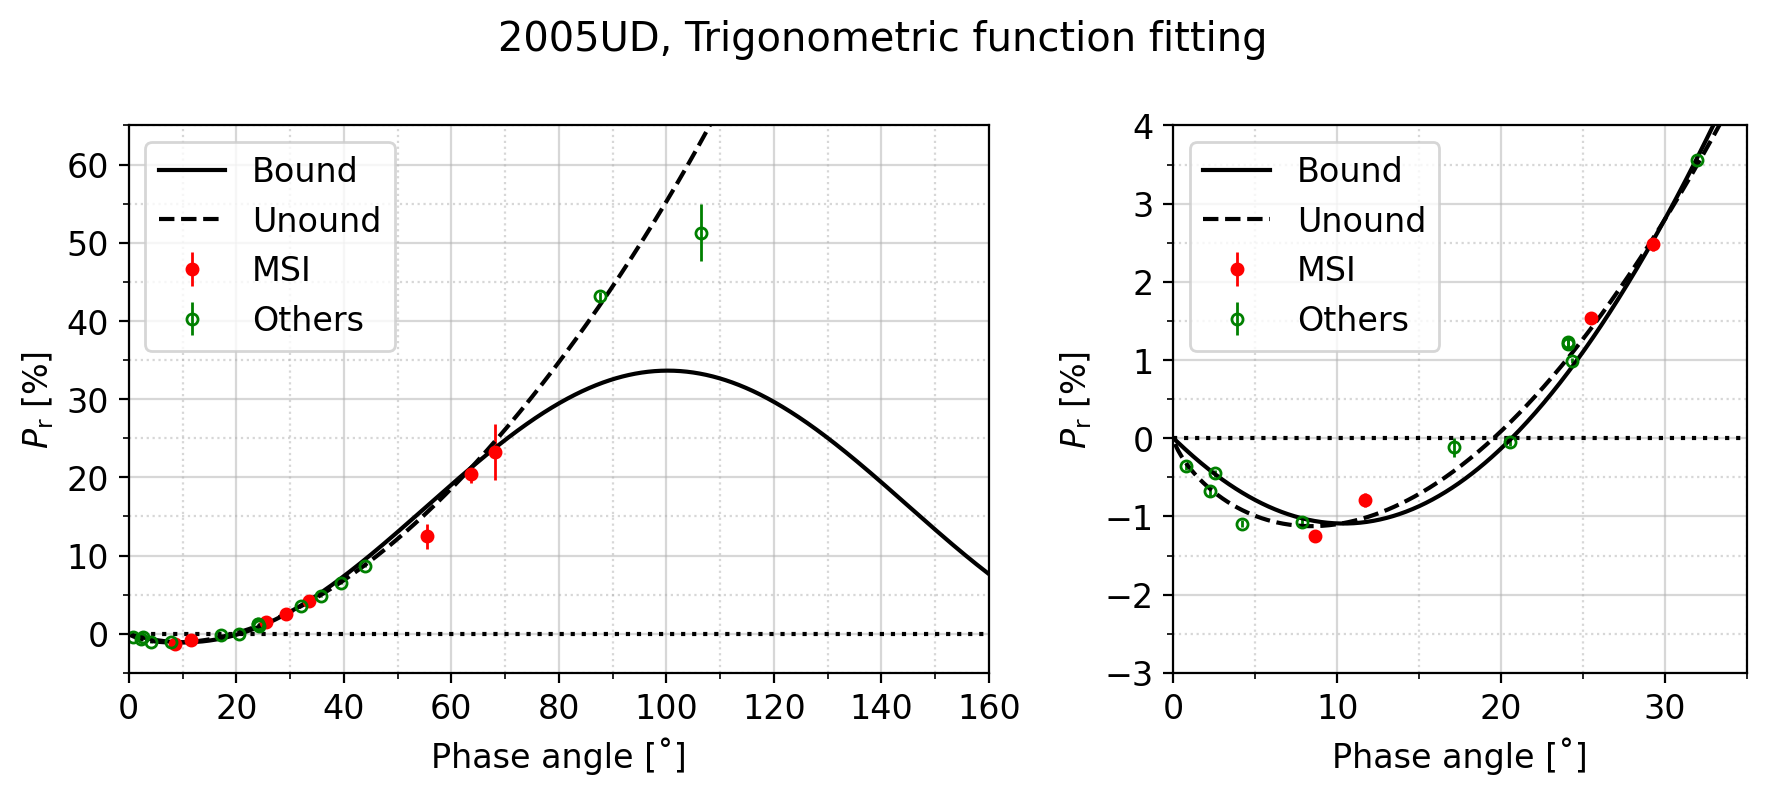

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=False, sharey=False, gridspec_kw=dict(width_ratios=[3, 2]))
util.plot_data(axs)
for ax in axs.flat:
    ax.plot(xx, fitfunc(xx, *popt_b), 'k-', label="Bound")
    ax.plot(xx, fitfunc(xx, *popt_f), 'k--', label="Unound")
    ax.legend(loc=2)

fig.suptitle("2005UD, Trigonometric function fitting")
fig.tight_layout()

plt.savefig(SAVEPATH / "observation-fit.png")
plt.savefig(SAVEPATH / "observation-fit.pdf")

Simple least-square fit will give the following best-fit parameters with the diagonal components as the variance of parameters when the $\chi^2$ contour are N-D ellipse (which is not used for error analysis):

In [23]:
print("Least Square fit & elliptical approximation errors with Scipy curve_fit\n")

for model, popt, pcov in zip(["Bound", "Unbound"], [popt_b, popt_f], [pcov_b, pcov_f]):
    amin, Pmin = fmin(np.arange(0, 20, 0.01), *popt)
    amax, Pmax = fmax(np.arange(80, 180, 0.01), *popt)
    print(f"{model} case")
    print(" h[%/˚]  a0[˚]     c1       c2       amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
    print(f" {popt[0]:.4f}  {popt[1]:.4f}   {popt[2]:.4f}   {popt[3]:.4f}  {amin:.2f}     {Pmin:.2f}    {amax:.2f}  {Pmax:.2f}")
    print("±{:.4f}  ±{:.4f}  ±{:.4f}  ±{:.4f}\n".format(*np.sqrt(np.diag(pcov))))

Least Square fit & elliptical approximation errors with Scipy curve_fit

Bound case
 h[%/˚]  a0[˚]     c1       c2       amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
 0.2109  20.6354   1.0132   0.0000  10.38     -1.09    100.25  33.65
±0.0031  ±0.1007  ±0.0197  ±0.0899

Unbound case
 h[%/˚]  a0[˚]     c1       c2       amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
 0.1921  19.5337   0.7413   -1.9350  8.41     -1.12    179.98  943624.01
±0.0026  ±0.1129  ±0.0155  ±0.0725



### 4-2. MCMC with ``pymc3``
Now that we got some clue about the initial parameters, do MCMC.

I assume all the parameters follow **uniform prior**, but only the lower/upper bounds of the parameters are subjectively set. 

**HERE I AM ASSUMING THE POWER PARAMETERS (C1 AND C2) ARE POSITIVE**. For non-bounded case, see section 5.

Run pymc3 for MCMC simulation:

In [24]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', pars_b['h'].low, pars_b['h'].upp)
    a0 = pm.Uniform('a0', pars_b['a0'].low, pars_b['a0'].upp)
    c1 = pm.Uniform('c1', pars_b['c1'].low, pars_b['c1'].upp)
    c2 = pm.Uniform('c2', pars_b['c2'].low, pars_b['c2'].upp)

    sigma = theano.shared(np.asarray(dpolr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(alpha * D2R) / sin(a0 * D2R))**c1 
             * (cos(alpha * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (alpha - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=polr)
    start = {}
    for name, par in pars_b.items():
        start[name] = par.p0
    trace_b = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:49<00:00, 1643.52draws/s]
The acceptance probability does not match the target. It is 0.8860912740381818, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8946902281221026, but should be close to 0.8. Try to increase the number of tuning steps.


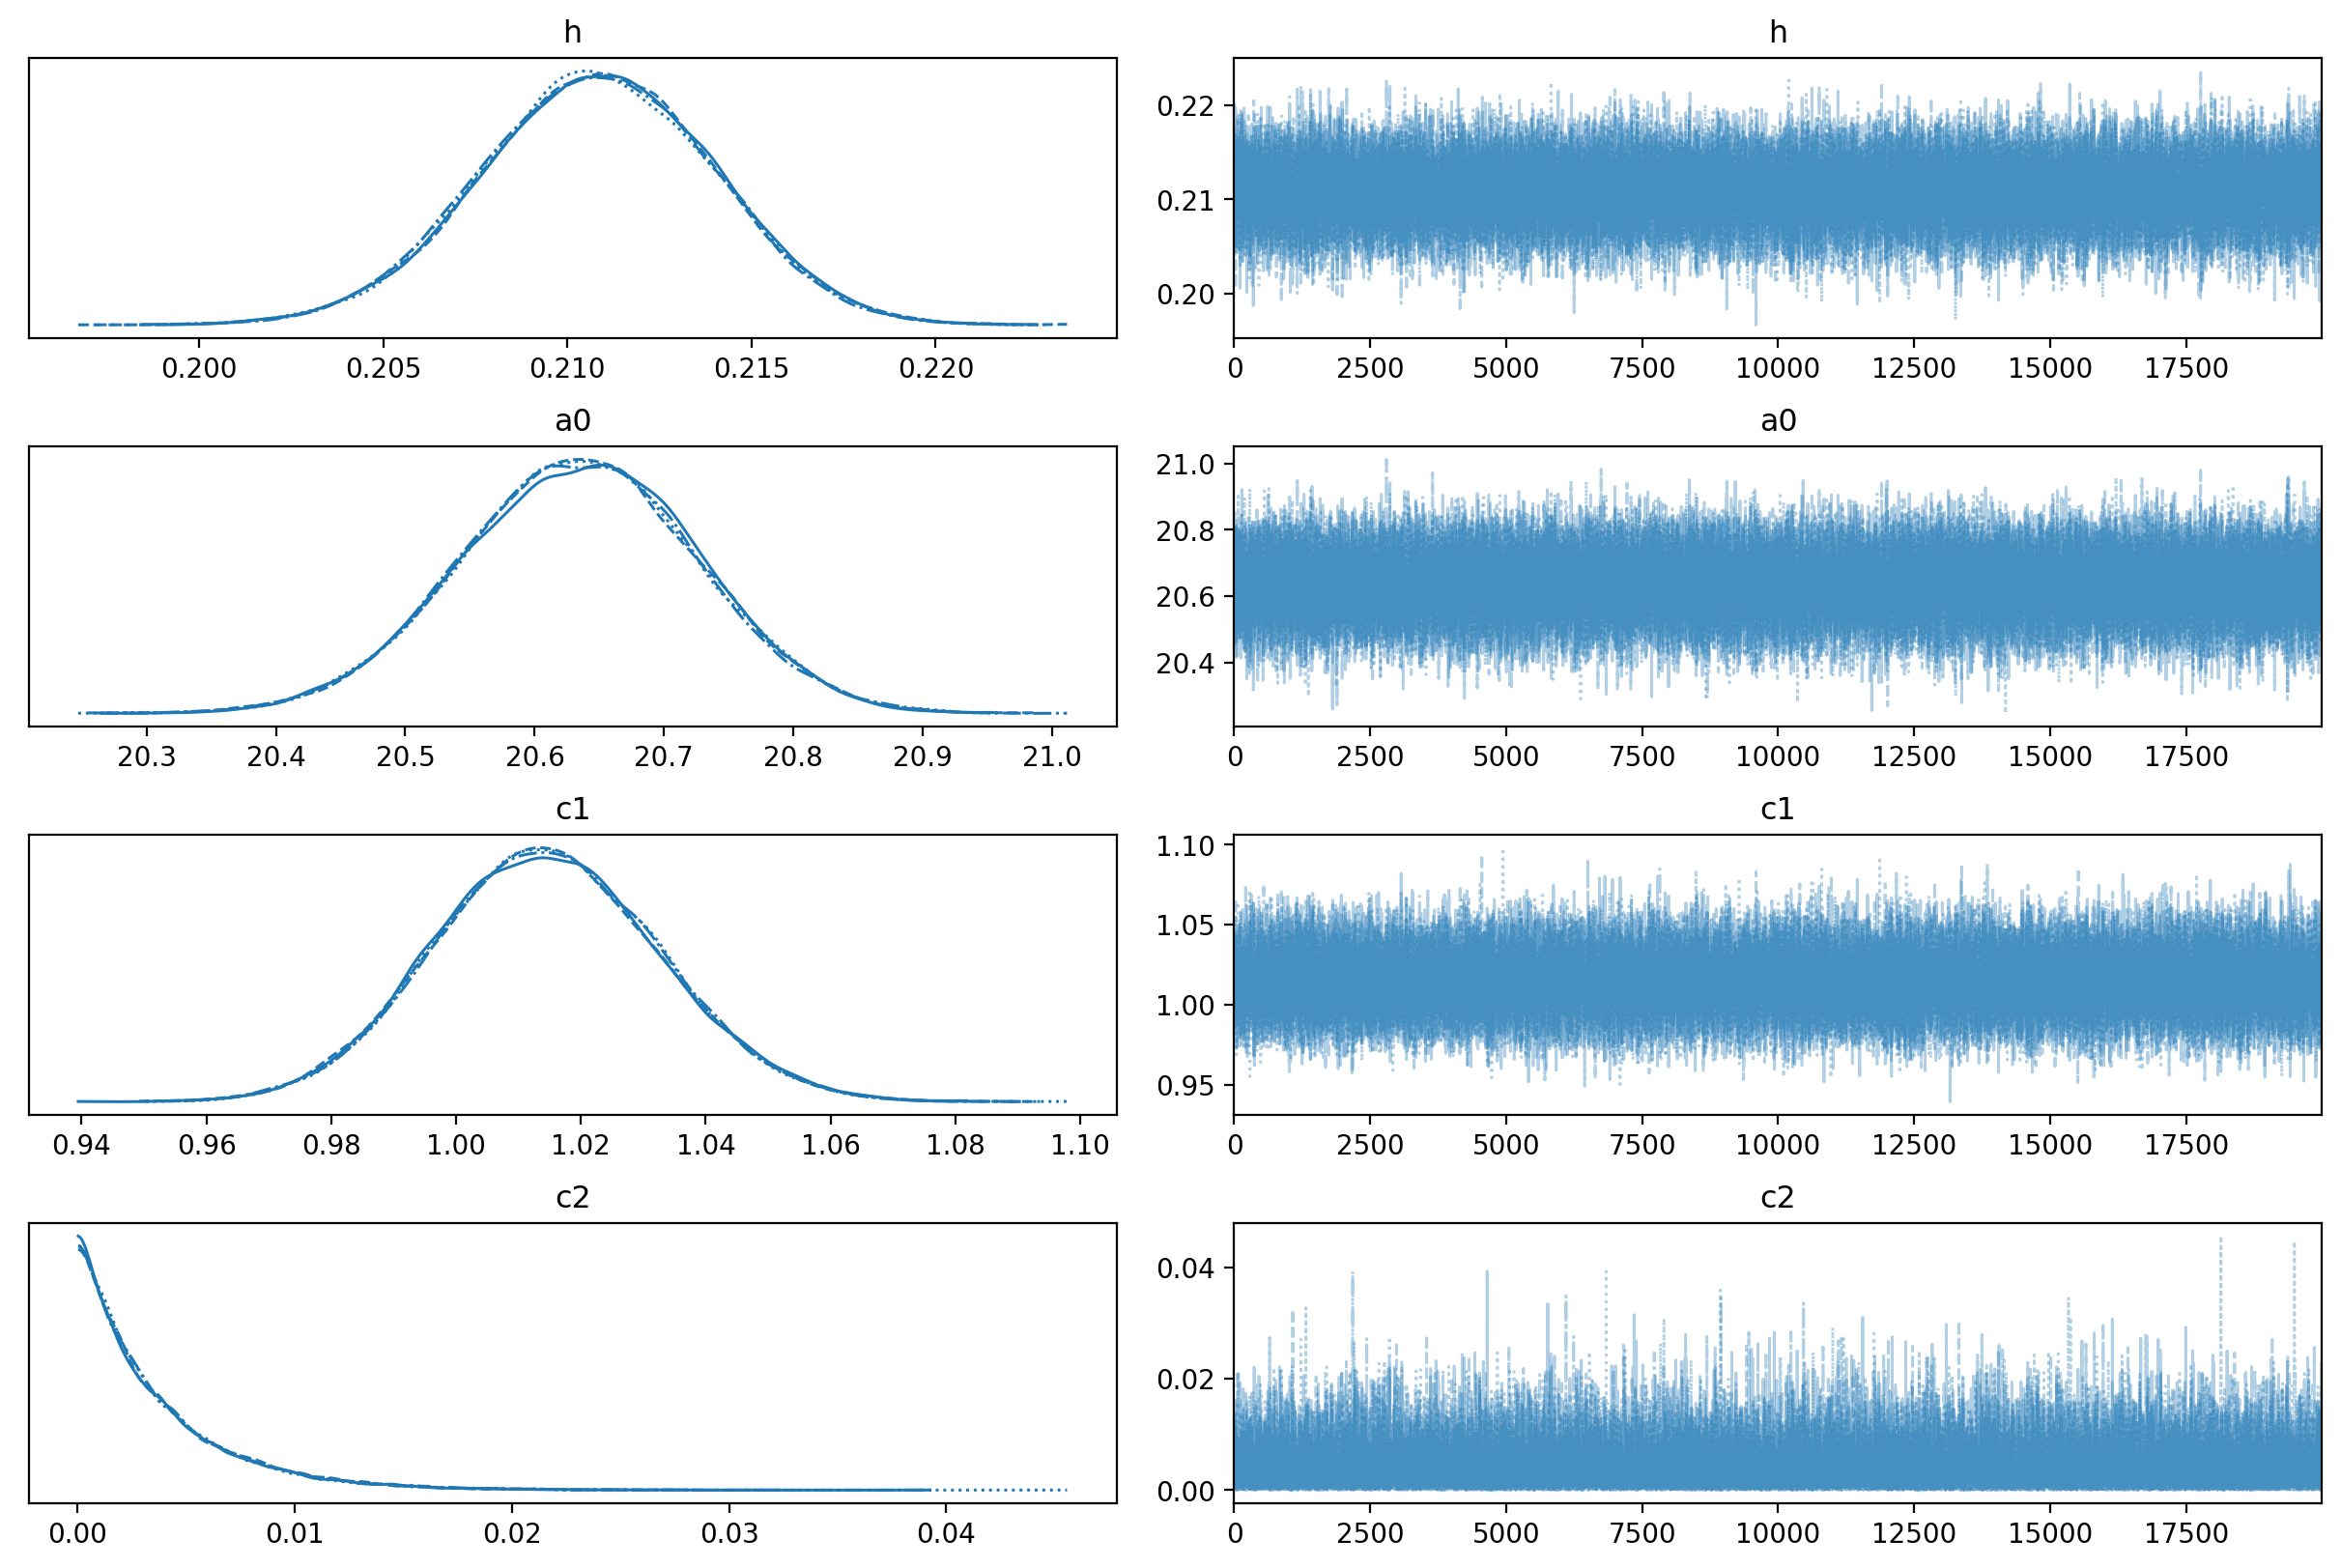

In [25]:
pm.traceplot(trace_b)
plt.savefig(SAVEPATH / "trace.png", dpi=300)
plt.savefig(SAVEPATH / "trace.pdf")

As can be seen, the trace looks very good except for c2. (see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect008.htm#statug.introbayes.bayesvisual))

The trace plot shows the "trace" of the Monte Carlo traces of the parameter space. Below I show the hpd (Highest Posterior Density) intervals for 1- and 3-sigma level are shown. 

In Bayesian sense, the posterior mean and standard deviation are used as parameter estimation and estimation error (e.g., see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect005.htm#statug.introbayes.bayesinterval)), while ``mc_error`` can be understood as an uncertainty intrinsic to this simulation due to the finite number of simulations (defined as ``sd/n_eff``). This should never be understood of the parameter uncertainty.

In [26]:
pm.summary(trace_b, credible_interval=0.6827).round(5)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
h    0.211  0.003   0.205    0.217        0.0      0.0   37066.0  37066.0   
a0  20.634  0.092  20.458   20.802        0.0      0.0   42601.0  42601.0   
c1   1.015  0.018   0.981    1.049        0.0      0.0   44174.0  44096.0   
c2   0.004  0.004   0.000    0.010        0.0      0.0   52809.0  52809.0   

    ess_bulk  ess_tail  r_hat  
h    37166.0   36974.0    1.0  
a0   42643.0   43343.0    1.0  
c1   44280.0   42525.0    1.0  
c2   34335.0   25437.0    1.0

In summary, $ h = 0.216 \pm 0.003 \,[\%/^\circ] $ etc, for $ \mathrm{mean \pm std} $ notation.

3-σ can be calculated by the following code, if you want.
```python
pm.summary(trace_b, credible_interval=0.9973).round(5)  # 3-sigma
```

### 4-3. Chi-Square Analysis
In the chi-square sense, what we have to do are
1. Calculate the chi-square statistic at each parameter space position. 
2. Keep only those with $\chi^2 < \chi^2_\mathrm{min} + \Delta(\nu, \alpha)$ 
    * $\Delta$: inverse cdf (cumulative distribution function) of $\chi^2$ distribution.
    * $\alpha$: significance level ($\alpha = 0.6827$ for 1-σ)
    * $\nu$: number of free parameters.
3. These are the models "within 1-sigma level confidence interval".
4. Get the min/max of each of the parameters and set these as lower/upper limit of the parameters.
5. The "center" of the parameters can be obtained by simple maximum likelihood estimation, such as least-square fitting.

Since it's difficult to sample all the 4-D paramter space, I used the traced parameter values from the MCMC above. 

Summarize for the models with 1-sigma chi-square value:

In [27]:
# Merge all the samples from the MCMC into a numpy ndarray:
samples_b = np.array([trace_b.get_values(k) for k in pars_b.keys()]).T

# Do Chi-2 analysis
delta = chi2.ppf(0.6827, n_param)

n_trace_b = trace_b['h'].shape[0]
res_b = dict(h=trace_b['h'], c1=trace_b['c1'], c2=trace_b['c2'], a0=trace_b['a0'],
           chi2=np.zeros(n_trace_b),
           amax=np.zeros(n_trace_b), amin=np.zeros(n_trace_b),
           Pmax=np.zeros(n_trace_b), Pmin=np.zeros(n_trace_b))

dofunc(
    alpha, polr, dpolr,
    arr_h=res_b["h"], arr_a0=res_b["a0"], arr_c1=res_b["c1"], arr_c2=res_b["c2"], 
    arr_chi2=res_b["chi2"], arr_amax=res_b["amax"], arr_Pmax=res_b["Pmax"], arr_amin=res_b["amin"], arr_Pmin=res_b["Pmin"]
)

chi2_min_b = res_b["chi2"].min()
mask_1sig_b = res_b["chi2"] < (chi2_min_b + delta)
# mask_1sig = res_b["chi2"] < (chi2_min_b + np.sqrt(2/(y.shape[0]-n_param)))

res_df_b = pd.DataFrame(res_b)
res_1sig_b = res_df_b[mask_1sig_b]

The min/max of ``res_1sig_b`` for each column (parameters) will be 1-sigma bounds of them (summarized below). Those of ``res_df_b`` gives the 1-σ bounds for α_min/max and P_min/max.

Summarize:

In [28]:
param_tab_b = dict(pars=list(pars_b.keys()) + ["amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt_b, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab_b["pars"]):
    pmin = res_1sig_b[p].min()
    pmax = res_1sig_b[p].max()
    p_hi = abs(pmax - param_tab_b["lsqs"][i])
    p_lo = abs(param_tab_b["lsqs"][i] - pmin)
    
    param_tab_b["mins"].append(pmin)
    param_tab_b["maxs"].append(pmax)
    param_tab_b["plus"].append(p_hi)
    param_tab_b["minus"].append(p_lo)
    
param_tab_b = pd.DataFrame.from_dict(param_tab_b)
param_tab_b

pars           lsqs           plus         minus        mins        maxs
0     h       0.210944       0.006443  6.750795e-03    0.204193    0.217387
1    a0      20.635389       0.190159  1.954926e-01   20.439896   20.825548
2    c1       1.013187       0.038986  3.711285e-02    0.976074    1.052173
3    c2       0.000001       0.008646  3.921751e-08    0.000001    0.008647
4  amin       8.410000       2.180000  1.770000e+00   10.180000   10.590000
5  Pmin      -1.124076       0.096086  2.691874e-02   -1.150995   -1.027990
6  amax     179.980000      79.520000  7.996000e+01  100.020000  100.460000
7  Pmax  943624.006184  943589.462638  9.435912e+05   32.767940   34.543546

That is, for example, $h = 0.2165 ^{+0.0068}_{-0.0071} \,[\%/^\circ] $ such that the min/max are 0.2094 and 0.2233. (the exact value may slightly change from time to time especially the error-bars, because it's basically random sampling of finite number of samples)

Comparing the above values with the previous table's ``min`` and ``max`` of each parameter, we now have the best fit parameter and uncertainty ranges in chi-square senses.

### 4-5. Pairplot of Parameters

Draw a corner plot

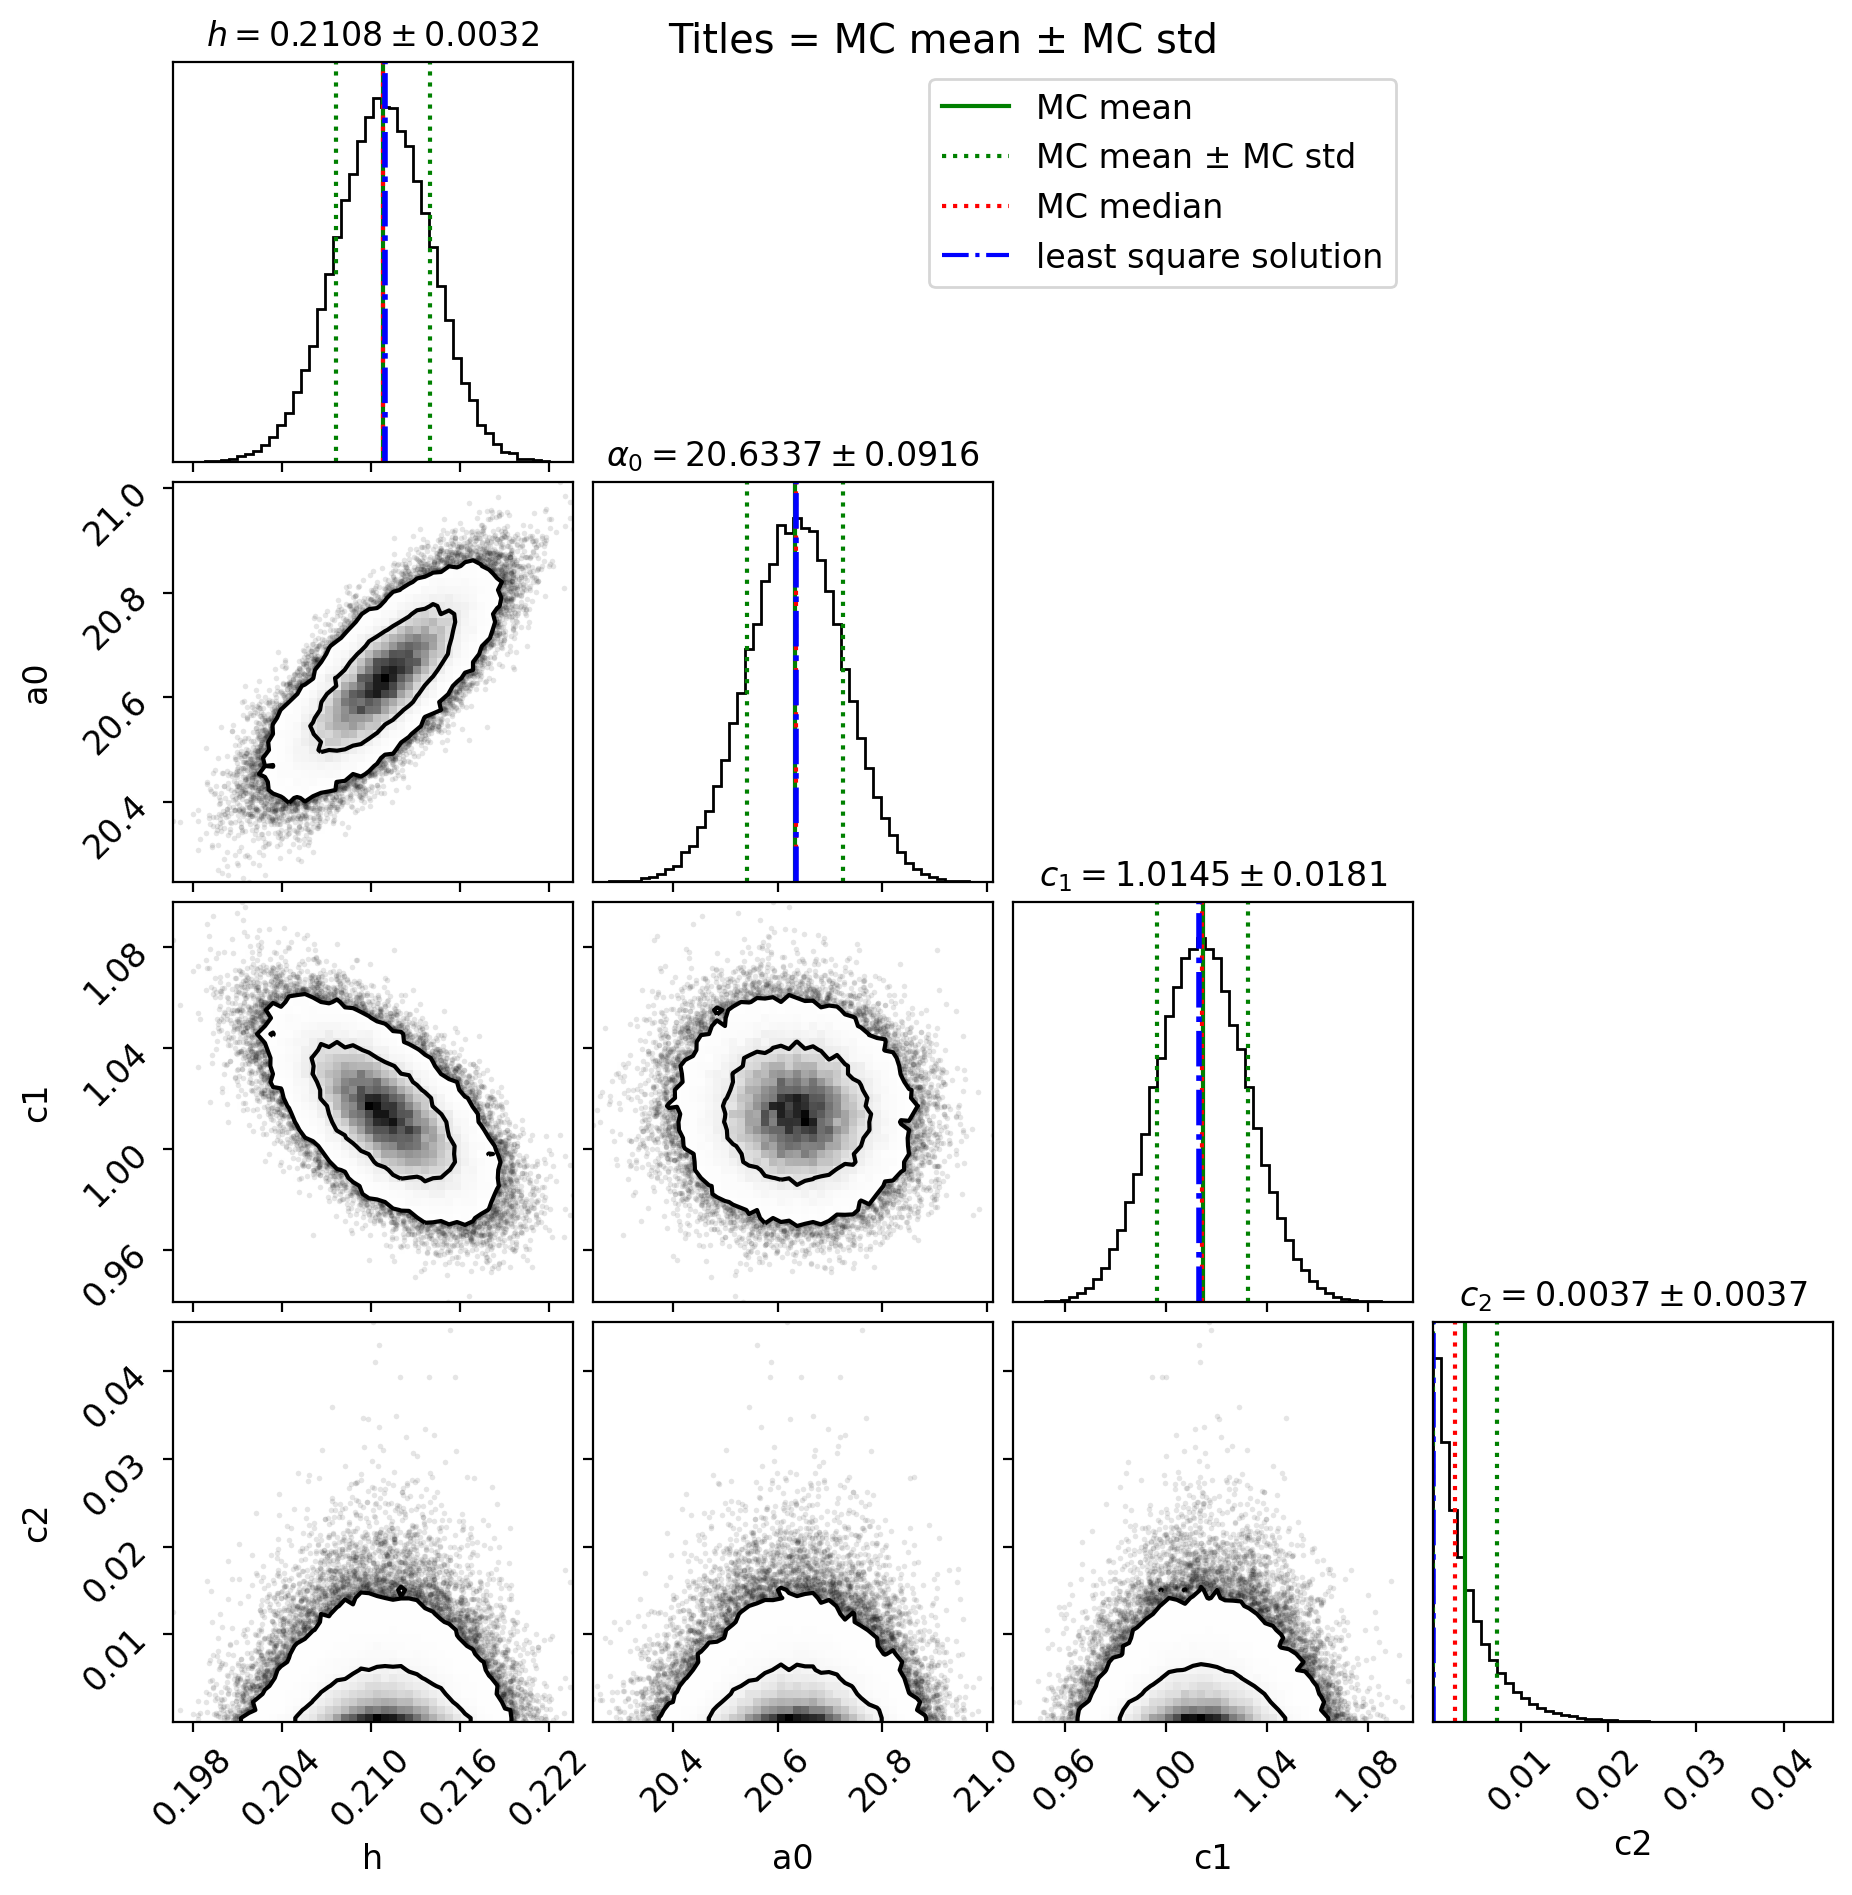

In [30]:
trace_df_b = pm.trace_to_dataframe(trace_b)
means_b = np.mean(trace_df_b, axis=0)
meds_b = np.median(trace_df_b, axis=0)
sds_b = np.std(trace_df_b, axis=0, ddof=1)
varnames = dict(h='h', a0='\\alpha_0', c1='c_1', c2='c_2')

fig = corner.corner(
    trace_df_b, 
#     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
    levels=[0.6827, 0.9545], #, 0.9973
    bins=50,
    show_titles=False,
    title_fmt='5.3f',
    title_kwargs={'fontsize': 12}
)
axes = np.array(fig.axes).reshape((n_param, n_param))

# Loop over the diagonal
for i in range(n_param):
    ax = axes[i, i]
    ax.axvline(means_b[i], color="g", ls='-')
    ax.axvline(means_b[i] - sds_b[i], color="g", ls=':')
    ax.axvline(means_b[i] + sds_b[i], color="g", ls=':')
    ax.axvline(meds_b[i], color="r", ls=':')
    ax.axvline(popt_b[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace_b.varnames[n_param+i]],
                                                     means_b[i],
                                                     sds_b[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std")
plt.savefig(SAVEPATH/"corner.pdf")
plt.savefig(SAVEPATH/"corner.png", dpi=300);

You may use ``seaborn`` which is extremely slow in this case:
```python
trace_df = pm.trace_to_dataframe(trace)
# sns.pairplot(,
#              kind='reg', markers='+')

g = sns.PairGrid(trace_df, diag_sharey=False)
g.map_lower(sns.kdeplot, kind='reg')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
```

### 4-6. To LATEX Table
If you want to save the resulting table as LaTeX format, for example, you may use the following python code:

In [31]:
from astropy.io.ascii.latex import latexdicts
from astropy.table import Table, vstack

tab_b = Table.from_pandas(param_tab_b)

for c in tab_b.colnames:
    try:    
        tab_b[c].format = '.4f'
    except ValueError:
        continue

tab_b.write(SAVEPATH / "test.tex", format='ascii.latex', latexdict=latexdicts["AA"])

``latexdicts["AA"]`` means it is in the format of A&A. You may use ``"AA"``, ``"doublelines"``, and ``"template"``.

It has the following output:

```latex
\begin{table}
\begin{tabular}{cccccc}
\hline \hline
pars & lsqs & plus & minus & mins & maxs \\
\hline
h & 0.2082 & 0.0178 & 0.0157 & 0.1925 & 0.2261 \\
c1 & 0.8647 & 0.1625 & 0.1120 & 0.7527 & 1.0273 \\
c2 & 0.0001 & 1.2607 & 0.0000 & 0.0001 & 1.2608 \\
a0 & 20.1849 & 0.6554 & 0.6485 & 19.5364 & 20.8404 \\
amin & 9.3800 & 1.0600 & 0.9000 & 8.4800 & 10.4400 \\
Pmin & -1.1692 & 0.1446 & 0.1485 & -1.3176 & -1.0246 \\
amax & 100.8100 & 0.5500 & 16.0500 & 84.7600 & 101.3600 \\
Pmax & 29.0842 & 3.4382 & 7.5246 & 21.5596 & 32.5224 \\
\hline
\end{tabular}
\end{table}
```

You may tune it as you wish...

## 5. What if no bound for powers?

In [32]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', pars_f['h'].low, pars_f['h'].upp)
    a0 = pm.Uniform('a0', pars_f['a0'].low, pars_f['a0'].upp)
    c1 = pm.Uniform('c1', pars_f['c1'].low, pars_f['c1'].upp)
    c2 = pm.Uniform('c2', pars_f['c2'].low, pars_f['c2'].upp)

    sigma = theano.shared(np.asarray(dpolr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(alpha * D2R) / sin(a0 * D2R))**c1 
             * (cos(alpha * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (alpha - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=polr)
    start = {}
    for name, par in pars_f.items():
        start[name] = par.p0
    trace_f = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:58<00:00, 1409.43draws/s]
The acceptance probability does not match the target. It is 0.8798910499112398, but should be close to 0.8. Try to increase the number of tuning steps.


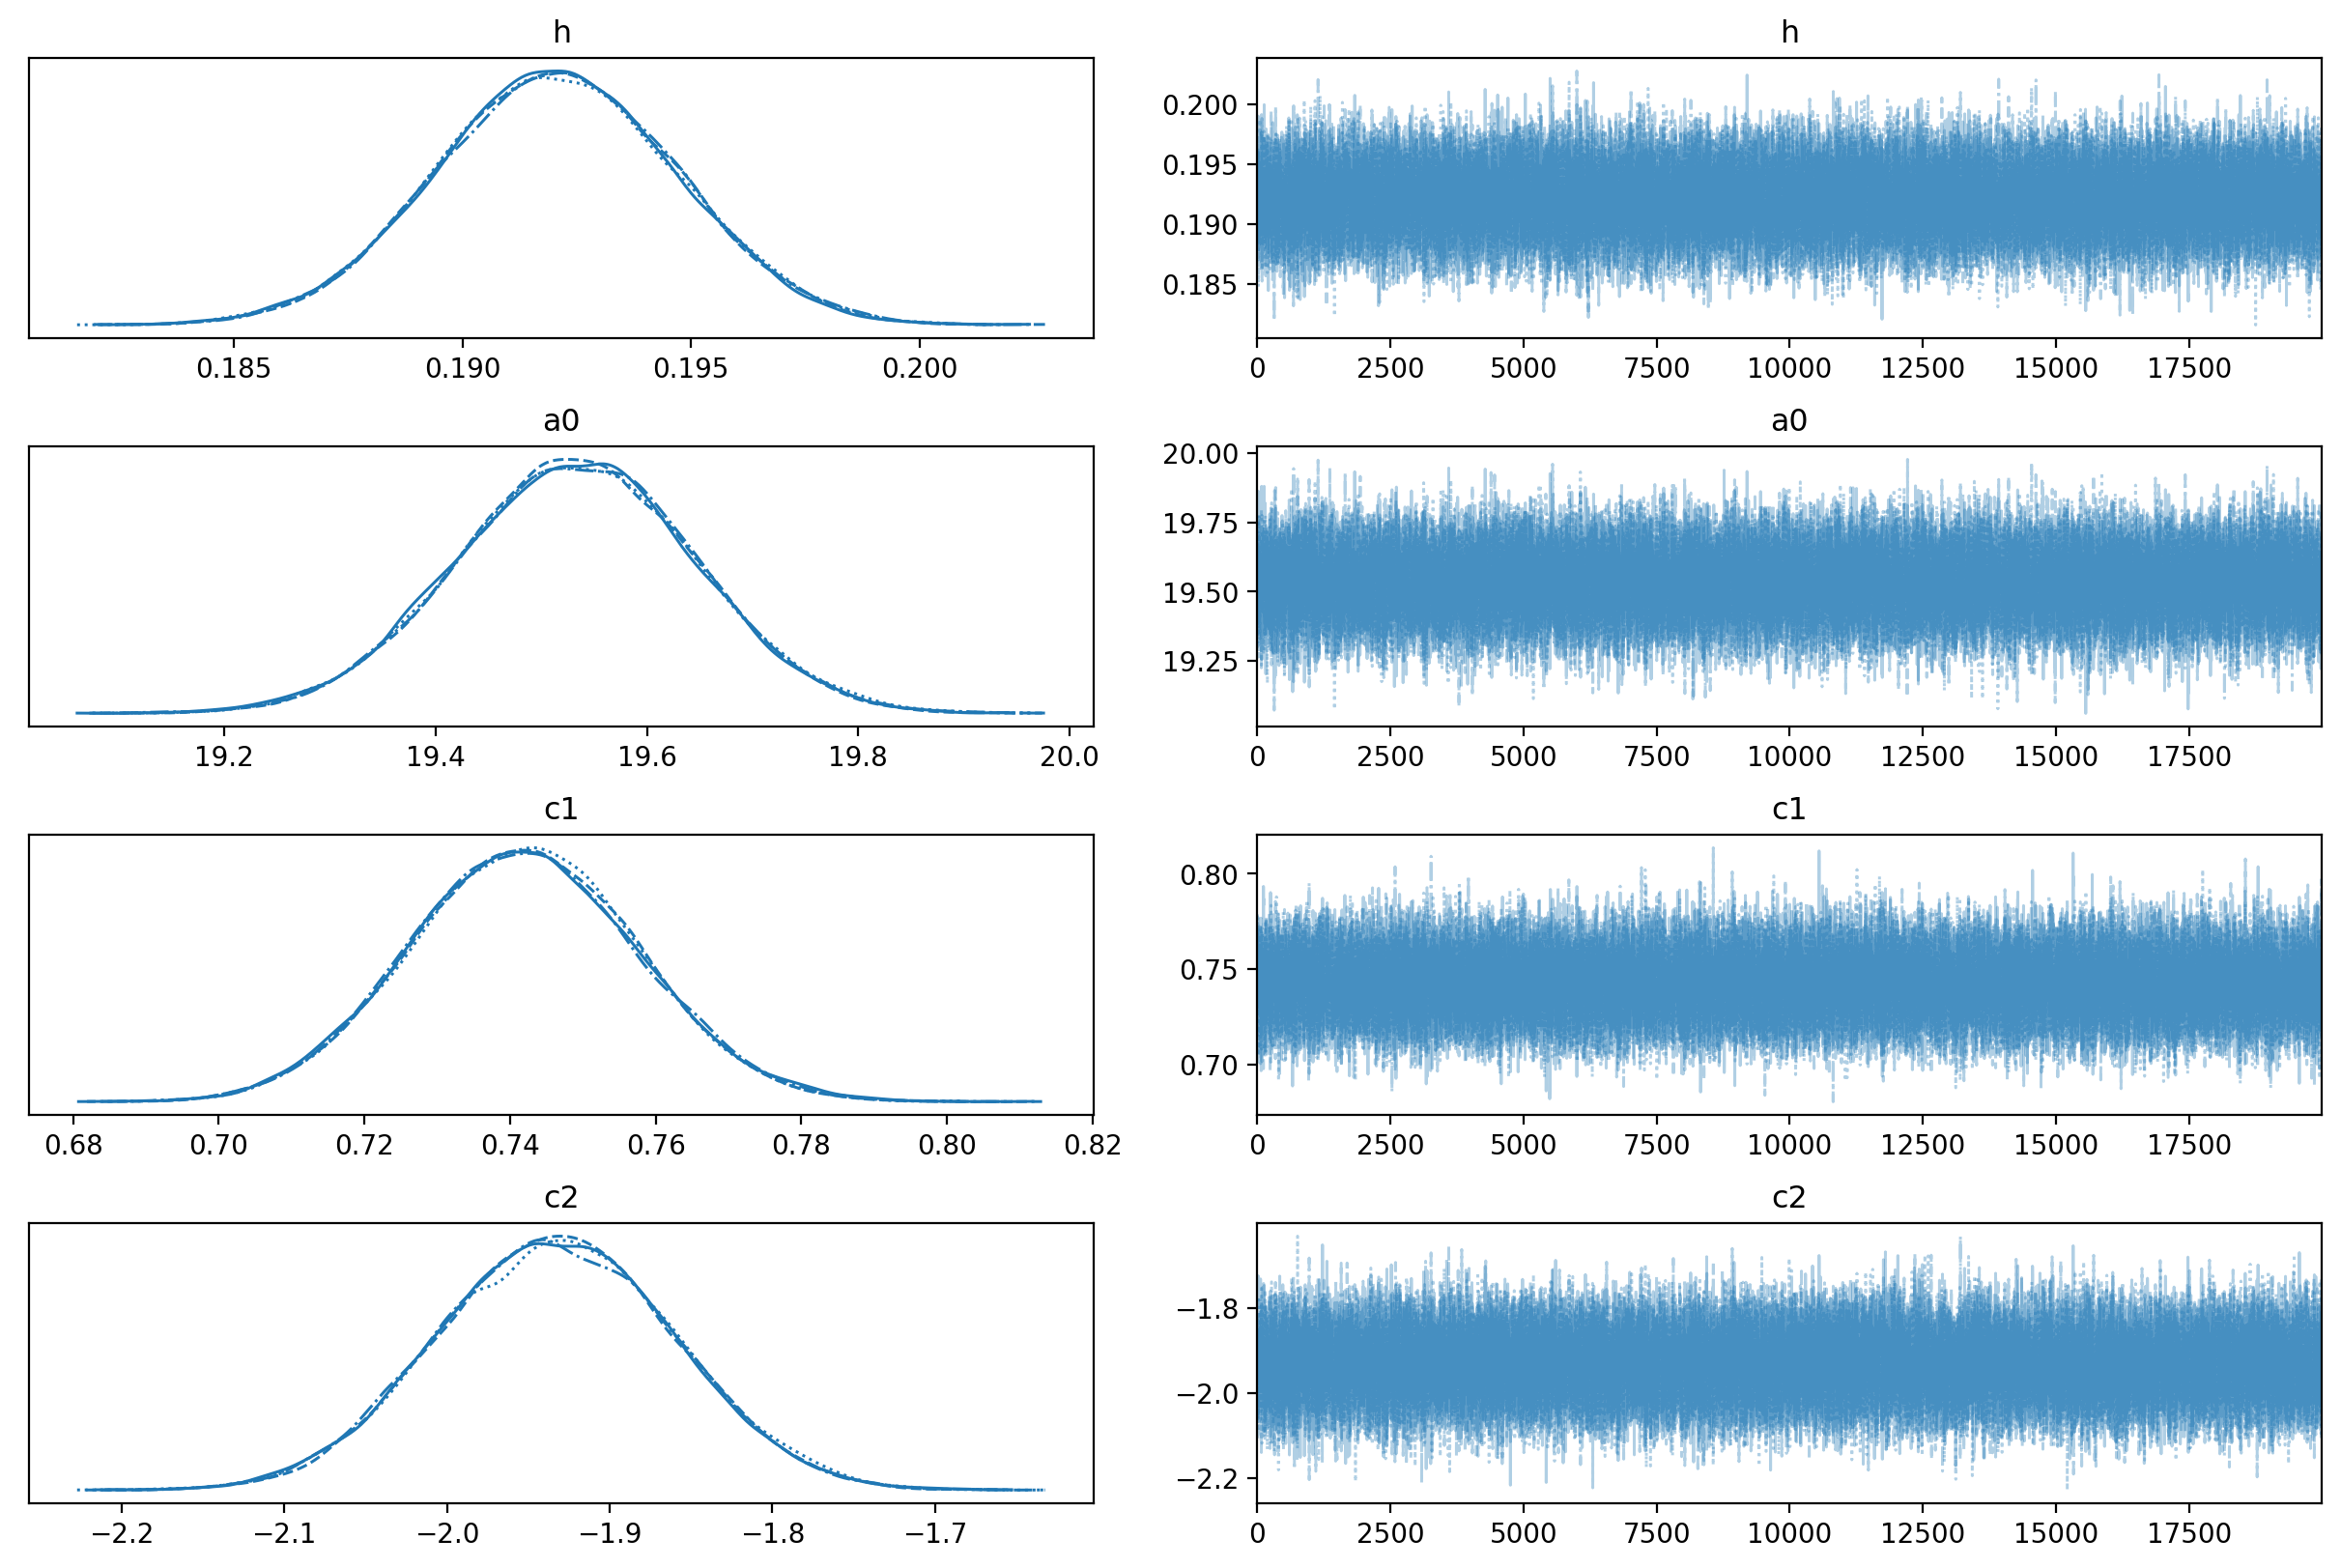

In [33]:
pm.traceplot(trace_f)
plt.savefig(SAVEPATH / "trace-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "trace-nobound.pdf")

In [34]:
pm.summary(trace_f, credible_interval=0.6827).round(5)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
h    0.192  0.003   0.187    0.197      0.000      0.0   30309.0  30309.0   
a0  19.532  0.113  19.318   19.744      0.001      0.0   29534.0  29534.0   
c1   0.742  0.016   0.713    0.771      0.000      0.0   33821.0  33786.0   
c2  -1.933  0.073  -2.071   -1.798      0.000      0.0   30326.0  30326.0   

    ess_bulk  ess_tail  r_hat  
h    30294.0   36694.0    1.0  
a0   29539.0   36405.0    1.0  
c1   33858.0   39108.0    1.0  
c2   30314.0   39346.0    1.0

In [36]:
# Merge all the samples from the MCMC into a numpy ndarray:
samples_f = np.array([trace_f.get_values(k) for k in pars_f.keys()]).T

# Do Chi-2 analysis
delta = chi2.ppf(0.6827, n_param)

n_trace_f = trace_f['h'].shape[0]
res_f = dict(h=trace_f['h'], c1=trace_f['c1'], c2=trace_f['c2'], a0=trace_f['a0'],
           chi2=np.zeros(n_trace_f),
           amax=np.zeros(n_trace_f), amin=np.zeros(n_trace_f),
           Pmax=np.zeros(n_trace_f), Pmin=np.zeros(n_trace_f))

dofunc(
    alpha, polr, dpolr,
    arr_h=res_f["h"], arr_a0=res_f["a0"], arr_c1=res_f["c1"], arr_c2=res_f["c2"], 
    arr_chi2=res_f["chi2"], arr_amax=res_f["amax"], arr_Pmax=res_f["Pmax"], arr_amin=res_f["amin"], arr_Pmin=res_f["Pmin"]
)

chi2_min_f = res_f["chi2"].min()
mask_1sig_f = res_f["chi2"] < (chi2_min_f + delta)
# mask_1sig = res_f["chi2"] < (chi2_min_f + np.sqrt(2/(y.shape[0]-4)))

res_df_f = pd.DataFrame(res_f)
res_1sig_f = res_df_f[mask_1sig_f]

h            c1            c2            a0          chi2  \
count  54091.000000  54091.000000  54091.000000  54091.000000  54091.000000   
mean       0.192058      0.741609     -1.934089     19.532526    150.064729   
std        0.002067      0.012198      0.057043      0.088524      1.200929   
min        0.186463      0.709282     -2.087707     19.293248    147.597939   
25%        0.190560      0.732730     -1.975801     19.468958    149.090612   
50%        0.192053      0.741610     -1.934250     19.532839    150.036887   
75%        0.193539      0.750394     -1.892550     19.596603    151.040972   
max        0.197630      0.774811     -1.780724     19.772949    152.317463   

               amax          amin          Pmax          Pmin  
count  5.409100e+04  54091.000000  54091.000000  54091.000000  
mean   1.399800e+02      8.410265    119.384270     -1.123756  
std    1.898588e-10      0.096983      6.251520      0.019297  
min    1.399800e+02      8.150000    103.538626     -1.176305  
25%    1.399800e+02      8.340000    114.766478     -1.137767  
50%    1.399800e+02      8.410000    119.261236     -1.123657  
75%    1.399800e+02      8.480000    123.852599     -1.109731  
max    1.399800e+02      8.670000    136.936875     -1.071526

In [54]:
param_tab_f = dict(pars=list(pars_f.keys()) + ["amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt_f, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab_f["pars"]):
    pmin = res_1sig_f[p].min()
    pmax = res_1sig_f[p].max()
    p_hi = abs(pmax - param_tab_f["lsqs"][i])
    p_lo = abs(param_tab_f["lsqs"][i] - pmin)
    
    param_tab_f["mins"].append(pmin)
    param_tab_f["maxs"].append(pmax)
    param_tab_f["plus"].append(p_hi)
    param_tab_f["minus"].append(p_lo)
    
param_tab_f = pd.DataFrame.from_dict(param_tab_f)
param_tab_f

pars           lsqs           plus          minus        mins        maxs
0     h       0.192089       0.005541       0.005626    0.186463    0.197630
1    a0      19.533694       0.239256       0.240446   19.293248   19.772949
2    c1       0.741350       0.033461       0.032067    0.709282    0.774811
3    c2      -1.934979       0.154255       0.152728   -2.087707   -1.780724
4  amin       8.410000       0.260000       0.260000    8.150000    8.670000
5  Pmin      -1.124076       0.052550       0.052229   -1.176305   -1.071526
6  amax     179.980000      40.000000      40.000000  139.980000  139.980000
7  Pmax  943624.006184  943487.069309  943520.467558  103.538626  136.936875

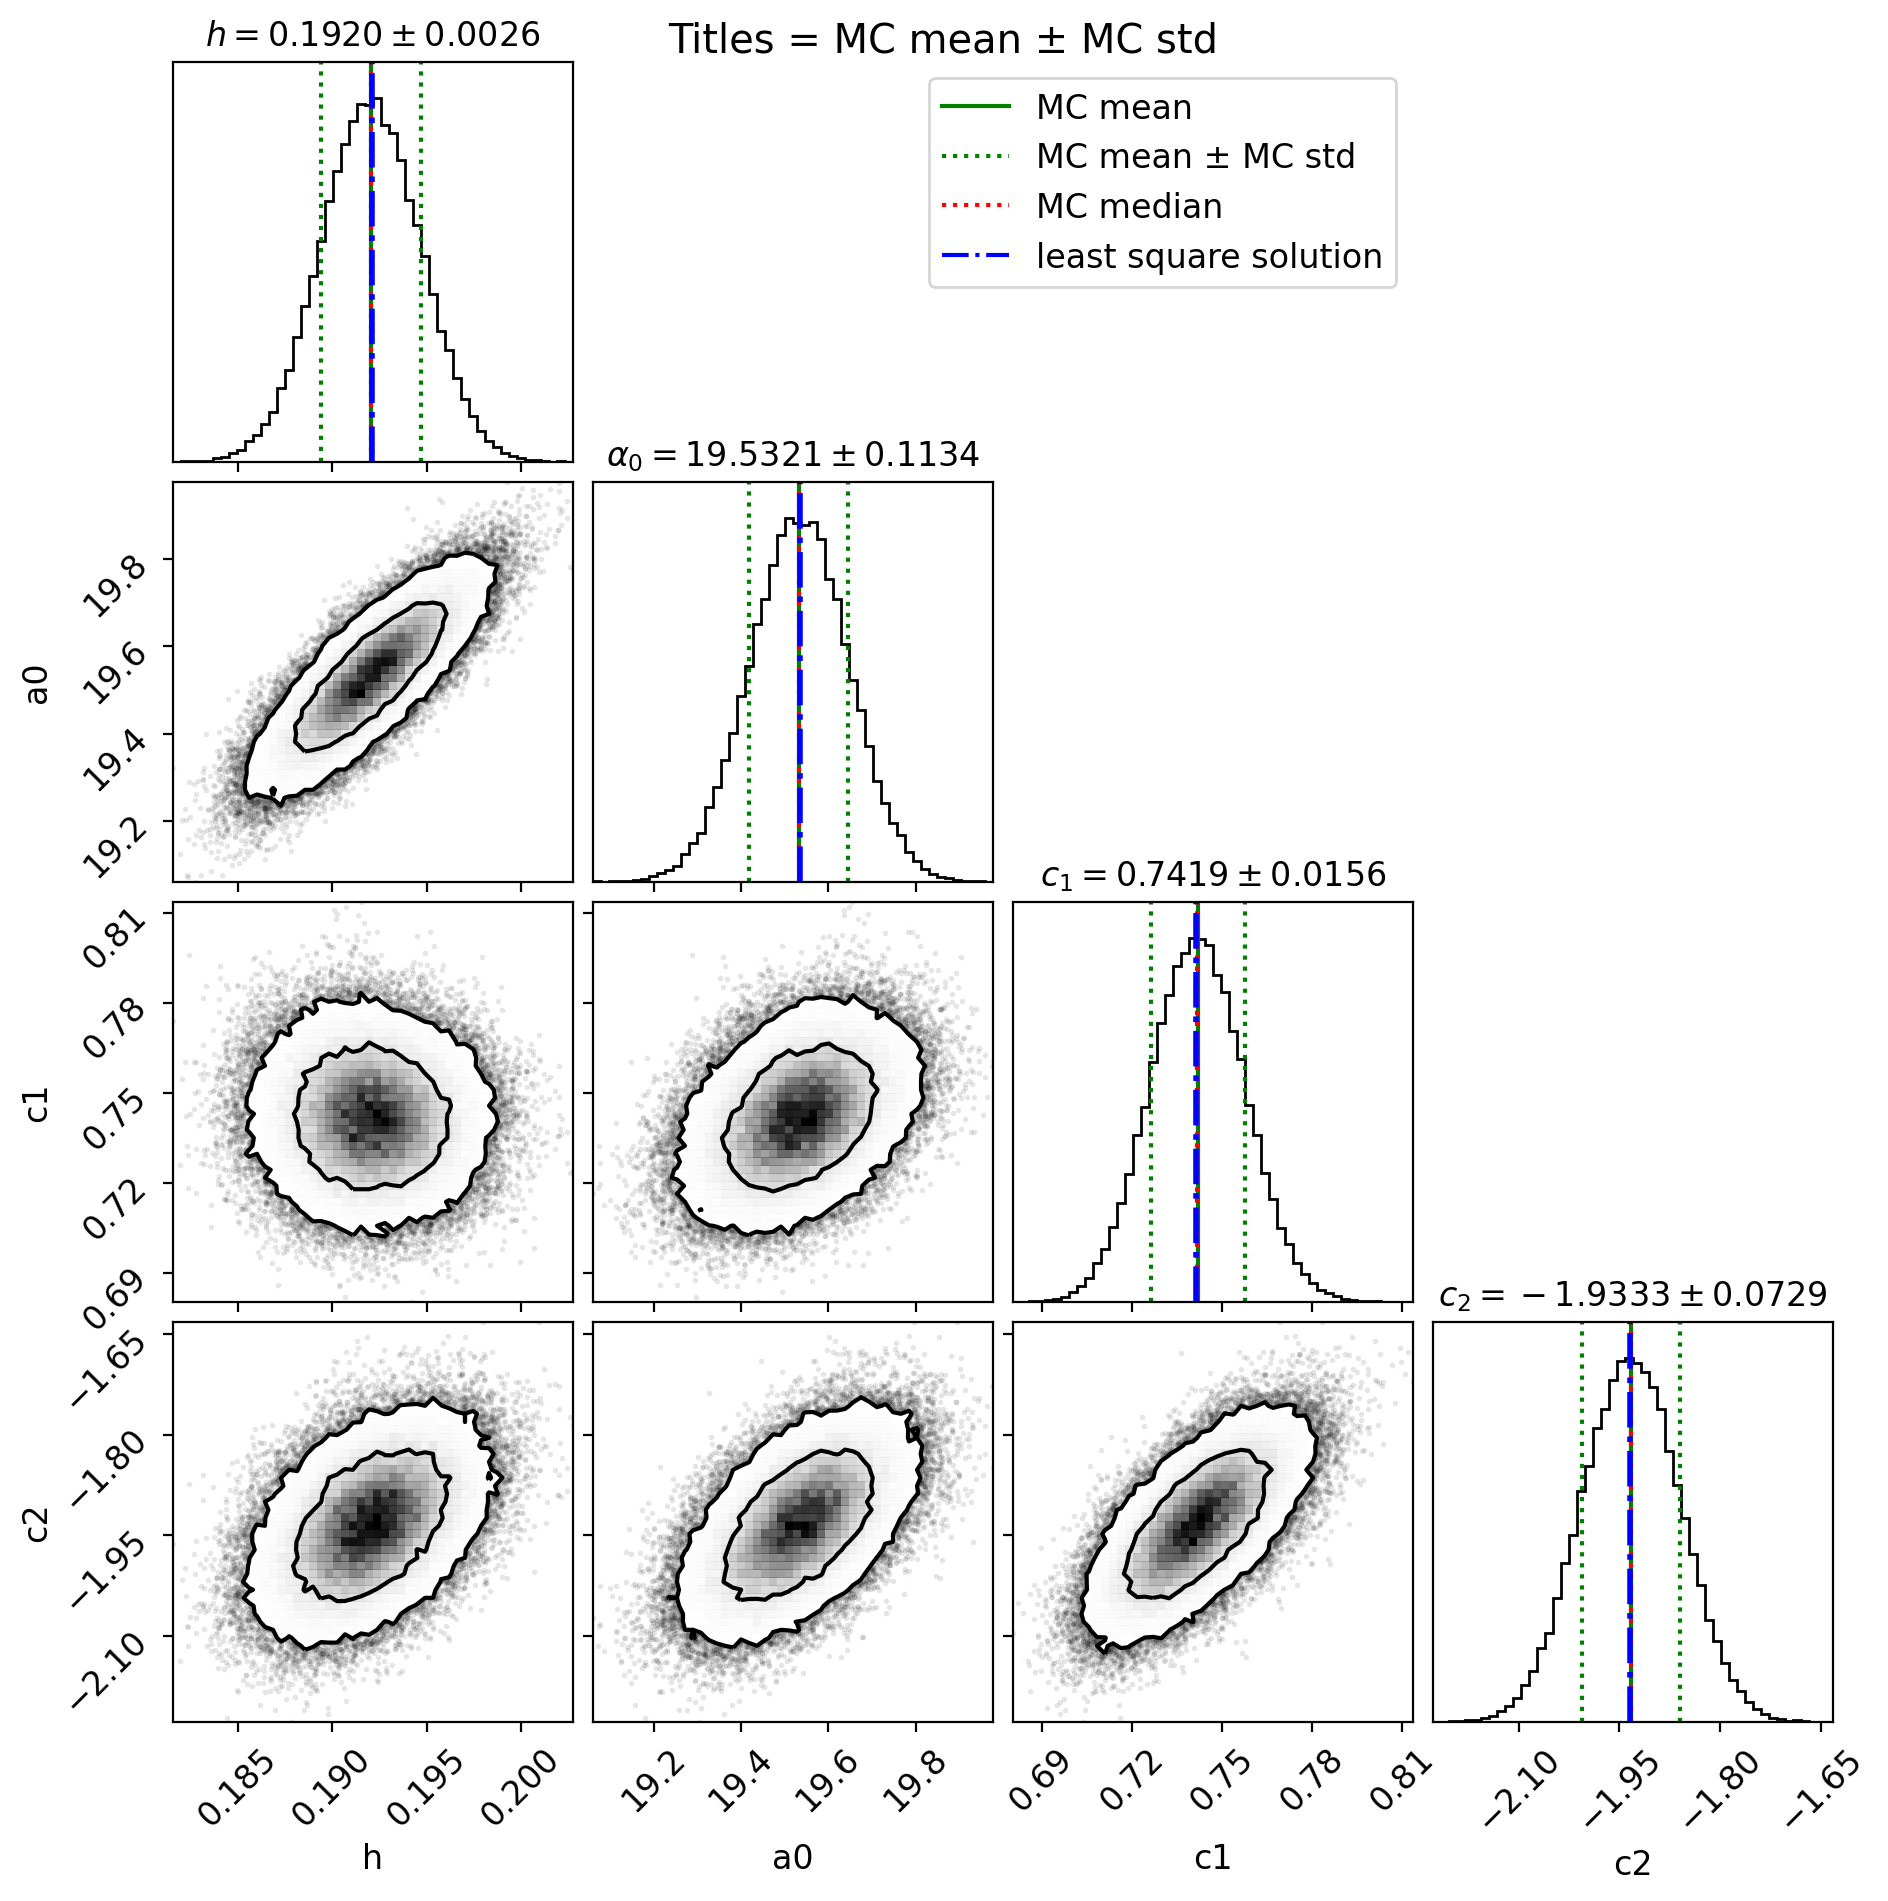

In [39]:
trace_df_f = pm.trace_to_dataframe(trace_f)
means_f = np.mean(trace_df_f, axis=0)
meds_f = np.median(trace_df_f, axis=0)
sds_f = np.std(trace_df_f, axis=0, ddof=1)
varnames = dict(h='h', a0='\\alpha_0', c1='c_1', c2='c_2')

fig = corner.corner(
    trace_df_f, 
#     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
    levels=[0.6827, 0.9545], #, 0.9973
    bins=50,
    show_titles=False,
    title_fmt='5.3f',
    title_kwargs={'fontsize': 12}
)
axes = np.array(fig.axes).reshape((n_param, n_param))

# Loop over the diagonal
for i in range(n_param):
    ax = axes[i, i]
    ax.axvline(means_f[i], color="g", ls='-')
    ax.axvline(means_f[i] - sds_f[i], color="g", ls=':')
    ax.axvline(means_f[i] + sds_f[i], color="g", ls=':')
    ax.axvline(meds_f[i], color="r", ls=':')
    ax.axvline(popt_f[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace_f.varnames[n_param+i]],
                                                     means_f[i],
                                                     sds_f[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std")
plt.savefig(SAVEPATH/"corner-nobound.pdf")
plt.savefig(SAVEPATH/"corner-nobound.png", dpi=300);

# Combined PPC (Both bound and unbound)

In [40]:
vals_b = [fitfunc(xx, *sample) for sample in samples_b]
vals_f = [fitfunc(xx, *sample) for sample in samples_f]
mins_b = np.min(vals_b, axis=0)
mins_f = np.min(vals_f, axis=0)
maxs_b = np.max(vals_b, axis=0)
maxs_f = np.max(vals_f, axis=0)


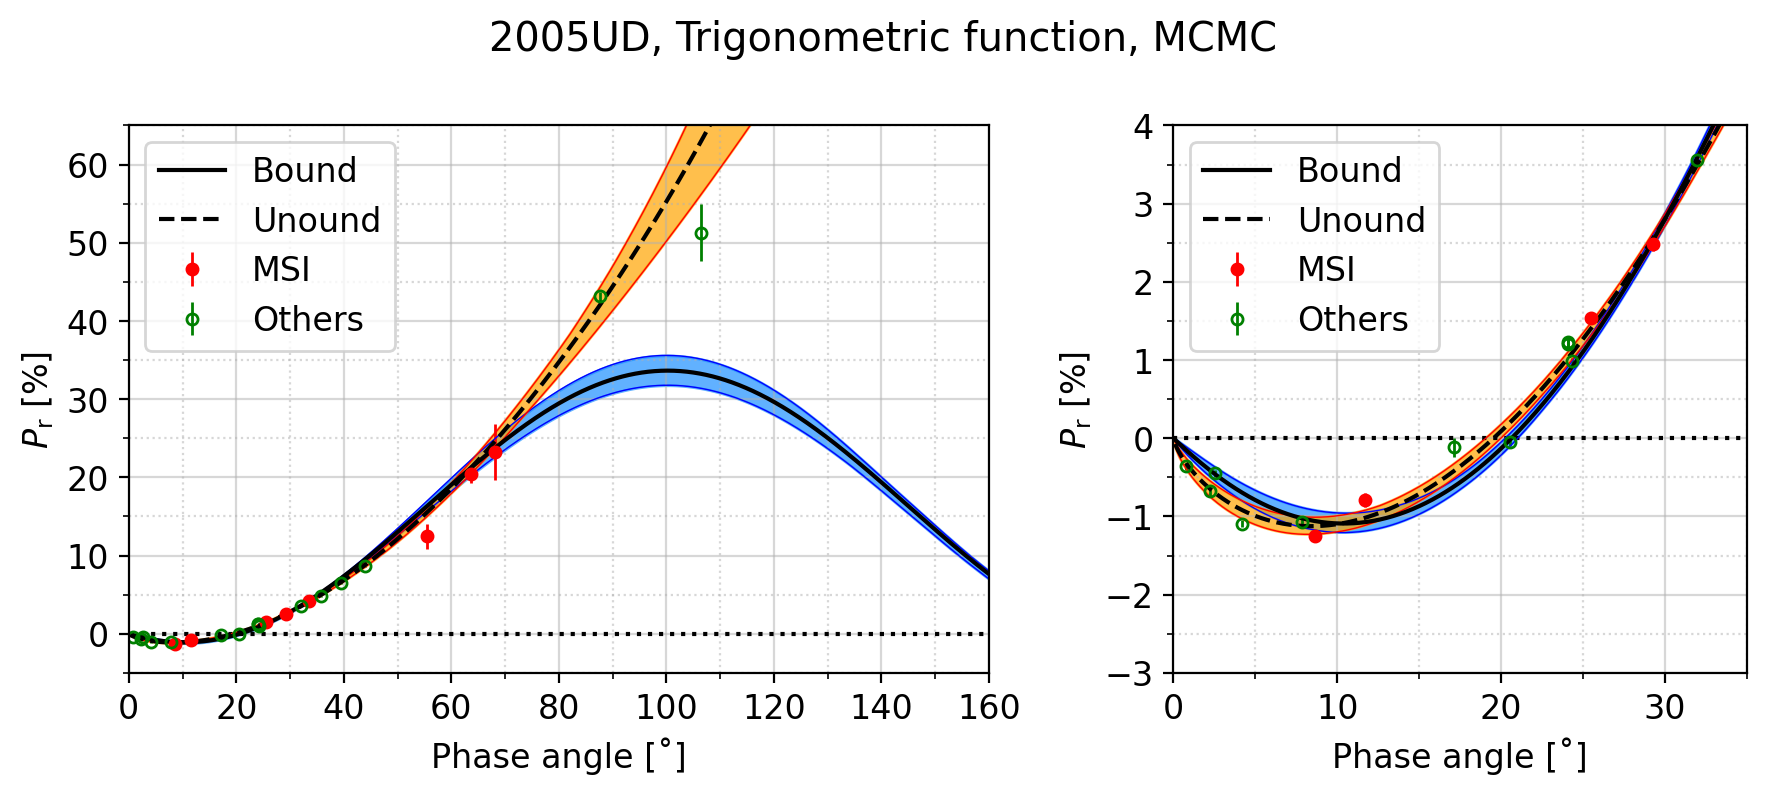

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=False, sharey=False, gridspec_kw=dict(width_ratios=[3, 2]))
util.plot_data(axs)
for ax in axs.flat:
    ax.fill_between(xx, mins_b, maxs_b, color='dodgerblue', alpha=0.7)
    ax.fill_between(xx, mins_f, maxs_f, color='orange', alpha=0.7)
    ax.plot(xx, mins_b, color='b', lw=0.5)
    ax.plot(xx, maxs_b, color='b', lw=0.5)
    ax.plot(xx, mins_f, color='r', lw=0.5)
    ax.plot(xx, maxs_f, color='r', lw=0.5)
    ax.plot(xx, fitfunc(xx, *popt_b), 'k-', label="Bound")
    ax.plot(xx, fitfunc(xx, *popt_f), 'k--', label="Unound")
    ax.legend(loc=2)

plt.suptitle("2005UD, Trigonometric function, MCMC")

plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc-comb.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc-comb.pdf")

In [ ]:
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was finished at {now} ")